# Identifying depression using stats

We run some statistical tests to identify trends among users that point to depression 

In [1]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
import statistics
from statsmodels.stats import weightstats as stests
from nltk.tokenize.casual import casual_tokenize
import re
from scipy import stats

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#read in the data
df = pd.read_csv('../Downloads/sentiment140.csv', header = None, encoding = "ISO-8859-1")
df.columns = ['target', 'id', 'date', 'flag', 'user', 'text'] #set column names
print(len(df))

df["words"] = [tuple([word for word in casual_tokenize(row.text) if not re.match('@', 
  word)]) for _, row in df.iterrows()]
df["num_words"] = [len(row.words) for _, row in df.iterrows()]
print(df.head())

1600498
   target  id                          date     flag      user  \
0       4   3  Mon May 11 03:17:40 UTC 2009  kindle2    tpryan   
1       4   4  Mon May 11 03:18:03 UTC 2009  kindle2    vcu451   
2       4   5  Mon May 11 03:18:54 UTC 2009  kindle2    chadfu   
3       4   6  Mon May 11 03:19:04 UTC 2009  kindle2     SIX15   
4       4   7  Mon May 11 03:21:41 UTC 2009  kindle2  yamarama   

                                                text  \
0  @stellargirl I loooooooovvvvvveee my Kindle2. ...   
1  Reading my kindle2...  Love it... Lee childs i...   
2  Ok, first assesment of the #kindle2 ...it fuck...   
3  @kenburbary You'll love your Kindle2. I've had...   
4  @mikefish  Fair enough. But i have the Kindle2...   

                                               words  num_words  
0  (I, loooooooovvvvvveee, my, Kindle, 2, ., Not,...         23  
1  (Reading, my, kindle, 2, ..., Love, it, ..., L...         14  
2  (Ok, ,, first, assesment, of, the, #kindle2, ....        

## Analysis 1

Plotting the average sentiment for each user

In [4]:
%%time
#create a dictionary { user : average sentiment} for users with 50+ tweets and not bots
average_sentiment = {}
users = df.user.value_counts()[df.user.value_counts() > 50] #minimum 50 tweets
for user in users.keys():
    tweet_set = df[df.user == user]
    if len(tweet_set.words.unique()) > 5: #filters bot spam
        average_sentiment[user] = sum(tweet_set.target) / len(tweet_set)
    else:
        del users[user]

CPU times: user 1min 44s, sys: 1.13 s, total: 1min 45s
Wall time: 1min 51s


Text(0, 0.5, 'Number of Users')

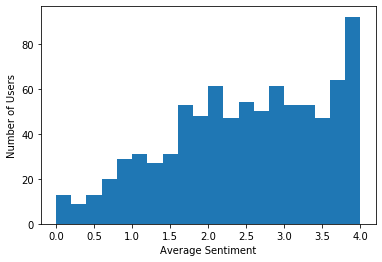

In [5]:
plt.hist(average_sentiment.values(), bins = 20)
plt.xlabel('Average Sentiment')
plt.ylabel('Number of Users')
#plt.savefig('average_sentiment50.png')

We noticed users tend to favor positive tweets 
so we run a z-test to see if it is statistically significant

#null hypothesis: population is a normal distribution
#alternate: users favor positive tweets

In [6]:
sample = list(average_sentiment.values())
# sample.sort()
# std = statistics.stdev(sample)
# mean = sum(sample)/len(sample)
ztest ,pval = stests.ztest(sample, x2=None, value=2, alternative='larger')
print(float(pval))
alpha = 0.01
if pval < alpha:
    print("reject null hypothesis")
else:
    print("accept null hypothesis")

5.638601821944252e-45
reject null hypothesis


## Analysis 2

According to Wang et al (2013), depressed users tweet less often, so we plot and test that

Text(0, 0.5, 'Number of Tweets')

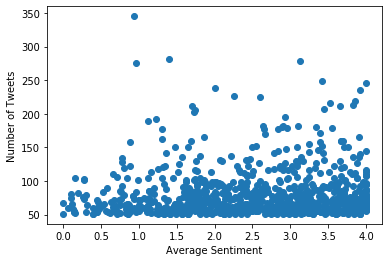

In [7]:
#plot tweeting frequency vs average sentiment
plt.scatter(average_sentiment.values(), users)
plt.xlabel('Average Sentiment')
plt.ylabel('Number of Tweets')
#plt.savefig('tweet_freq.png')

Testing if the tweet frequency is significantly different across a certain threshold of average sentiment (we found 0.7 gives the best result) using ANOVA

In [8]:
#anova test to see if users with low average_sentiment tweet less
low = {}
normal = {}
threshold = 0.7
for k,v in average_sentiment.items():
    if v < threshold:
        low[k] = users[k]
    else:
        normal[k] = users[k]
F, p = stats.f_oneway(tuple(low.values()), tuple(normal.values()))
print("p-value for significance is: ", p)
if p<0.01:
    print("reject null hypothesis")
else:
    print("accept null hypothesis")

p-value for significance is:  0.009997455983955883
reject null hypothesis


In [15]:
sum(normal.values()) / len(normal.values())

81.81549815498155

In [18]:
statistics.stdev(normal.values())

37.080992435478315

In [13]:
sum(low.values()) /len(low.values())

67.13953488372093

## Analysis 3

Wang et al. also mention that depressed users tweet more often between midnight and 6 am

In [9]:
%%time
#structuring the data
normal_times, dep_times = [], []
for user in users.keys():
    tweet_set = df[df.user == user]
    for _, tweet in tweet_set.iterrows():
        time = int(re.search('(\d{2}):', tweet.date)[1])
        if average_sentiment[user] > 0.7:
           normal_times.append(time)
        else:
           dep_times.append(time)

CPU times: user 1min 53s, sys: 879 ms, total: 1min 54s
Wall time: 2min 1s


Text(0, 0.5, 'number of tweets')

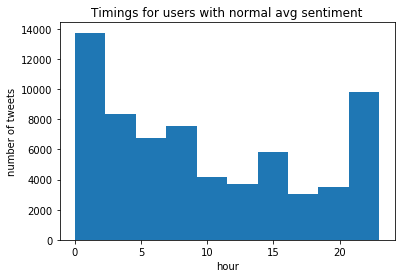

In [10]:
plt.hist(normal_times)
plt.title('Timings for users with normal avg sentiment')
plt.xlabel('hour')
plt.ylabel('number of tweets')

Text(0, 0.5, 'number of tweets')

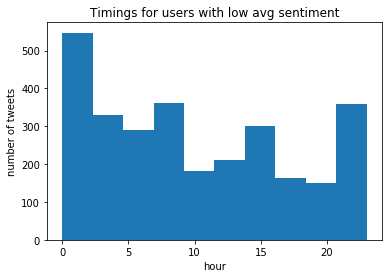

In [11]:
plt.hist(dep_times)
plt.title('Timings for users with low avg sentiment')
plt.xlabel('hour')
plt.ylabel('number of tweets')

use ANOVA to see if there is any statistically significant difference

In [12]:
F, p = stats.f_oneway(normal_times, dep_times)
print("p-value for significance is: ", p)
if p<0.01:
    print("reject null hypothesis")
else:
    print("accept null hypothesis")

p-value for significance is:  0.4077208397001345
accept null hypothesis


this last test found no significant difference